In [1]:
import numpy as np
import pandas as pd
from nltk import FreqDist
from nltk.tokenize import \
    regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import ttest_ind
import re
from collections import OrderedDict, defaultdict, Counter
import itertools
import string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = 150
seed = 7

In [2]:
# Loading dataset

In [3]:
df = pd.read_csv('./data/disaster_tweets/train.csv')
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
# Keyword and location columns

In [7]:
# Location column doesn't seem to have usable information. In some cases it's nonsense.

In [8]:
print('Sample of some of the location values')
df['location'].unique()[7:17].tolist()

Sample of some of the location values


['World Wide!!',
 'Paranaque City',
 'Live On Webcam',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim']

In [9]:
Counter(df['keyword'])

Counter({nan: 61,
         'ablaze': 36,
         'accident': 35,
         'aftershock': 34,
         'airplane%20accident': 35,
         'ambulance': 38,
         'annihilated': 34,
         'annihilation': 29,
         'apocalypse': 32,
         'armageddon': 42,
         'army': 34,
         'arson': 32,
         'arsonist': 34,
         'attack': 36,
         'attacked': 35,
         'avalanche': 30,
         'battle': 26,
         'bioterror': 37,
         'bioterrorism': 30,
         'blaze': 38,
         'blazing': 34,
         'bleeding': 35,
         'blew%20up': 33,
         'blight': 32,
         'blizzard': 37,
         'blood': 35,
         'bloody': 35,
         'blown%20up': 33,
         'body%20bag': 33,
         'body%20bagging': 33,
         'body%20bags': 41,
         'bomb': 34,
         'bombed': 38,
         'bombing': 29,
         'bridge%20collapse': 35,
         'buildings%20burning': 35,
         'buildings%20on%20fire': 33,
         'burned': 33,
         'bu

In [10]:
# I don't plan to use 'keyword' as a feature.
# It's just what was used to search for tweets.
# Filling missing values with 'missing_keyword' so I can visualize.

In [11]:
df['keyword'] = df['keyword'].fillna('missing_keyword')

In [12]:
df['keyword_count_0'] = \
    df['keyword'].apply(
        lambda x: Counter(df['keyword'][df['target'] == 0])[x]
        )
df['keyword_count_1'] = \
    df['keyword'].apply(
        lambda x: Counter(df['keyword'][df['target'] == 1])[x]
        )

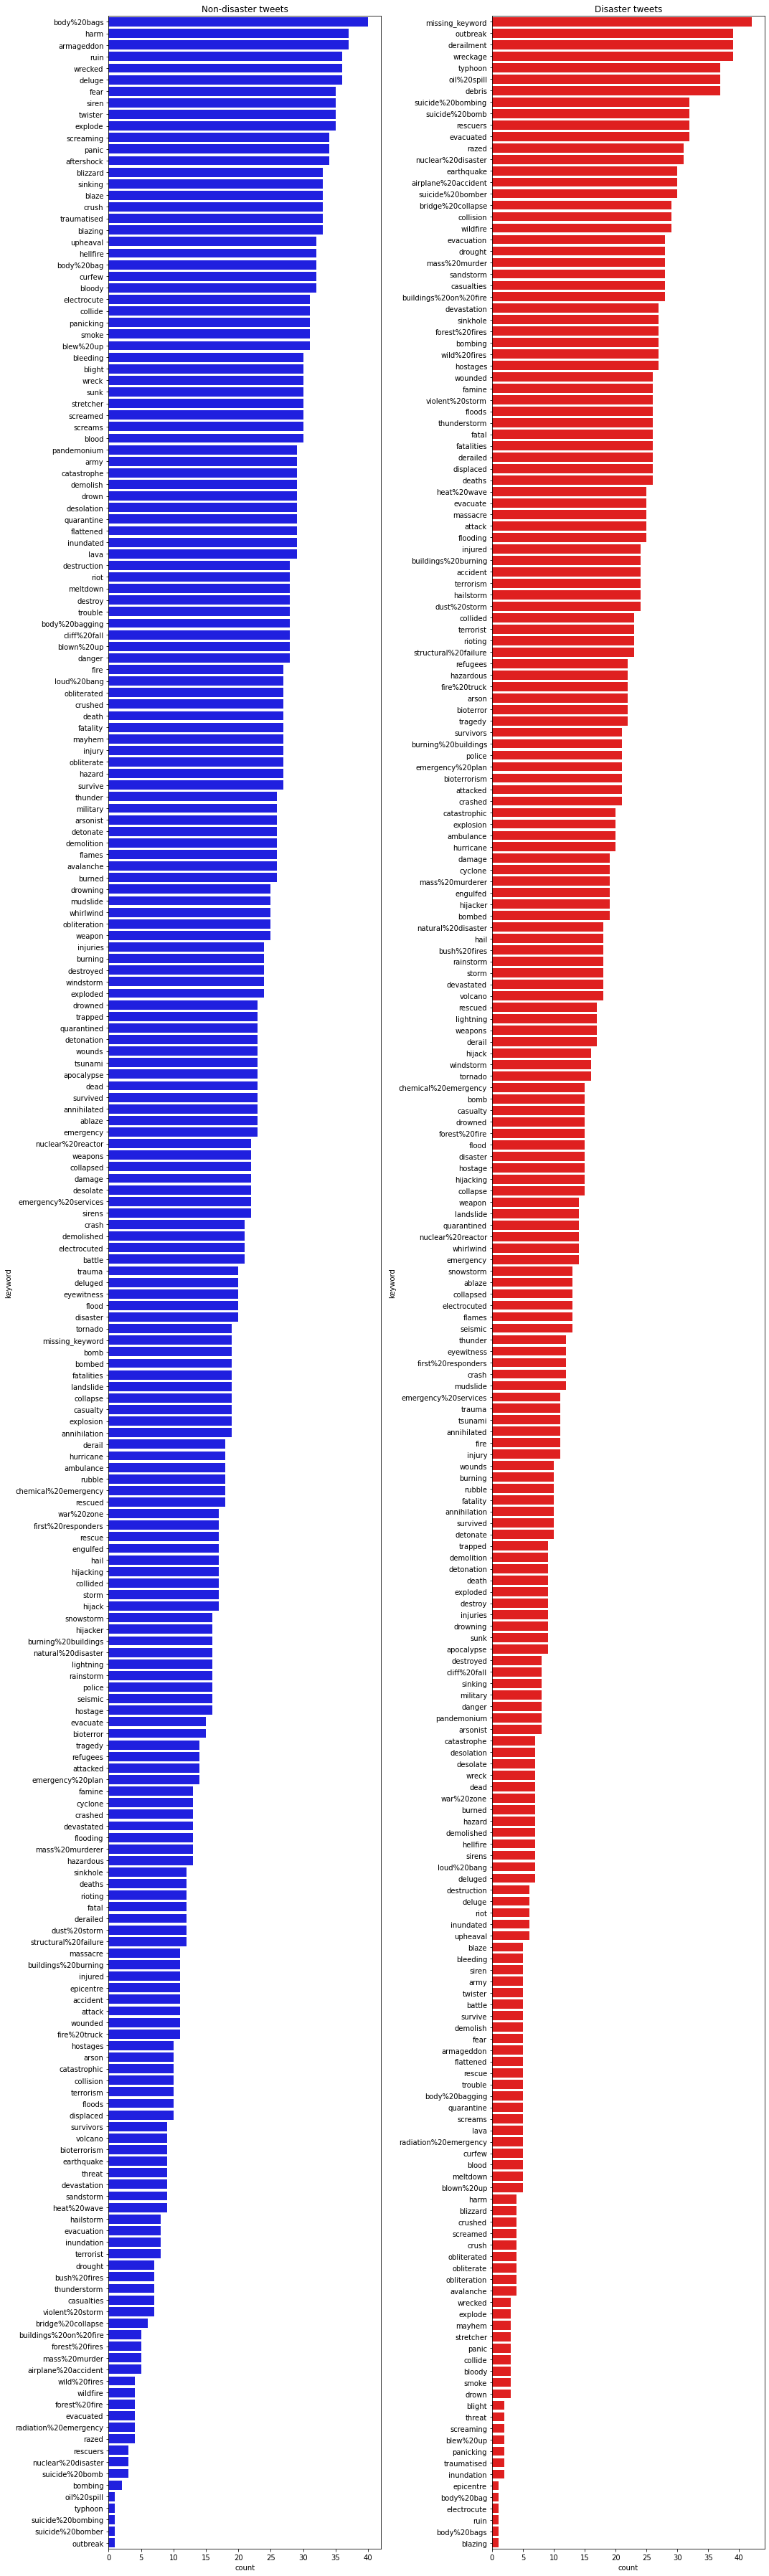

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 50))

sns.countplot(
    y=df[df['target']==0].sort_values(
        by='keyword_count_0', ascending=False
        )['keyword'],
    color='blue',
    ax=axes[0]
    )
sns.countplot(
    y=df[df['target']==1].sort_values(
        by='keyword_count_1', ascending=False
        )['keyword'],
    color='red',
    ax=axes[1]
    )

axes[0].set_title('Non-disaster tweets')
axes[1].set_title('Disaster tweets')

plt.tight_layout()
plt.show()

In [14]:
# Features and Target

In [15]:
tweets = df[['text']]
target = df['target']

In [16]:
print('Distribution of Target')
print
print(target.value_counts())
print()
print(target.value_counts(normalize=True))

Distribution of Target
0    4342
1    3271
Name: target, dtype: int64

0    0.57034
1    0.42966
Name: target, dtype: float64


In [17]:
# Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    tweets, target, test_size=.25, random_state=seed
)

In [19]:
# Cleaning and tokenizing the tweet text

In [20]:
# Saving a copy of untouched tweets
X_train_tweets_unprocessed = X_train.copy()['text'] 

In [21]:
X_train['text'] = X_train['text'].apply(lambda x: x.lower())

<ipython-input-21-cbb6d635a30d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text'] = X_train['text'].apply(lambda x: x.lower())


In [22]:
X_train.head(10)

,text
1489,@masochisticmage + catastrophe! it caused people to get reckless and the bottom line is that at least three of your friends will have +
5973,#nochilllukehammings\nim screaming
7589,omg earthquake
3788,it's never a good sign when you pull up to work &amp; there's five ambulances &amp; a fire truck in the bay. wompppp at least it's friday
825,my mic and controllers aren't working one second
4569,my baby girls car wreak this afternoon thank god no serious injuries and she was wearing her seatbelt!!!... http://t.co/njqv45nds2
6371,look at the previous battles. citizens were committing suicide so to not be under american control. the bomb was the only way. @nbcnews
4648,@mistresspip i'm amazed you have not been inundated mistress.
1812,maj muzzamil pilot offr of mi-17 crashed near mansehra today. http://t.co/kl4r1ccwct
492,christian attacked by muslims at the temple mount after waving israeli flag via pamela geller - ... http://t.co/f5miuhqaby


In [23]:
# Remove URLs

In [24]:
# Preserve if tweet has a URL. Will use this later.

def binary_url(text):
    """
    Returns 1 if a string contains a URL, else returns 0.
    """
    search = re.search(pattern=r'http\S+', string=text)
    return int(bool(search))

has_url_Series_train = X_train['text'].apply(binary_url).rename('has_url')

In [25]:
X_train['text'] = X_train['text'].apply(
    lambda x: re.sub(pattern=r'http\S+', repl='', string=x)
    )

<ipython-input-25-d605797eee16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text'] = X_train['text'].apply(


In [26]:
# Tokenizing

In [27]:
example_tweet = X_train['text'].loc[2372]
example_tweet

"such activities of govt can't derail us from our aim &amp; we still remain peaceful and unite for #freesikhpoliticalprisnors &amp; @bapusuratsingh"

In [28]:
X_train['text'].sample(5)

3668                                                                           dying of lyme disease: case fatality rate nearly 100% 
4351                                                  swansea û÷plot hijack transfer move for southampton target virgil van dijkûª 
6529                                                   #autoinsurance industry clueless on #driverlesscars : #markets : #money times 
1629                                                                                        the @potus economy continues to collapse.
1408    i'm laughing in the face of casualties and sorrow the first time i'm thinking past tomorrow but i am not throwin away my shot
Name: text, dtype: object

In [29]:
token_pattern = r"[a-zA-Z]+'?[a-zA-Z]+"
# Pattern: Any alphanumeric word with at least two characters, including up to one apostrophy

tokenizer = RegexpTokenizer(token_pattern)

In [30]:
tokenizer.tokenize(example_tweet)

['such',
 'activities',
 'of',
 'govt',
 "can't",
 'derail',
 'us',
 'from',
 'our',
 'aim',
 'amp',
 'we',
 'still',
 'remain',
 'peaceful',
 'and',
 'unite',
 'for',
 'freesikhpoliticalprisnors',
 'amp',
 'bapusuratsingh']

In [31]:
# seems to work
# But "amp" is an artifact of "&amp;" which is the HTML entity for "&"
# Replace it with "and" in original text
# Then tokenize

In [32]:
X_train['text'] = X_train['text'].apply(lambda x: re.sub("&amp;", "and", x))

<ipython-input-32-f7ec564c15b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text'] = X_train['text'].apply(lambda x: re.sub("&amp;", "and", x))


In [33]:
X_train['tokens'] = X_train['text'].apply(tokenizer.tokenize)

<ipython-input-33-6b2ecea3c3fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['tokens'] = X_train['text'].apply(tokenizer.tokenize)


In [34]:
# Remove stopwords
# Get comprehensive list
# Combine stopwords from two libraries: NLTK and SpaCy

In [35]:
sw_spacy = list(nlp.Defaults.stop_words)
sw_nltk = stopwords.words('english')
stopword_list = list(set(sw_spacy + sw_nltk))

In [36]:
X_train['tokens_no_sw'] = \
    X_train['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

<ipython-input-36-7eda8e6ff0b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['tokens_no_sw'] = \


In [37]:
# Check most common words

In [38]:
FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)

[('like', 264),
 ('fire', 200),
 ("i'm", 184),
 ('new', 176),
 ('news', 164),
 ('people', 151),
 ('video', 119),
 ('disaster', 115),
 ('police', 110),
 ('emergency', 108),
 ('time', 101),
 ('body', 95),
 ('suicide', 90),
 ('california', 90),
 ('storm', 90),
 ('burning', 89),
 ('rt', 88),
 ('crash', 87),
 ('world', 84),
 ('man', 83)]

In [39]:
# "i'm" should also be considered a stop word

In [40]:
stopword_list.extend(["i'm"])

In [41]:
X_train['tokens_no_sw'] = \
    X_train['tokens'].apply(
        lambda x: [w for w in x if not w in stopword_list]
    )

<ipython-input-41-7eda8e6ff0b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['tokens_no_sw'] = \


In [42]:
top_20_no_sw = FreqDist(X_train['tokens_no_sw'].explode()).most_common(20)
top_20_no_sw

[('like', 264),
 ('fire', 200),
 ('new', 176),
 ('news', 164),
 ('people', 151),
 ('video', 119),
 ('disaster', 115),
 ('police', 110),
 ('emergency', 108),
 ('time', 101),
 ('body', 95),
 ('suicide', 90),
 ('california', 90),
 ('storm', 90),
 ('burning', 89),
 ('rt', 88),
 ('crash', 87),
 ('world', 84),
 ('man', 83),
 ('bomb', 82)]

In [43]:
X_train.head()

,text,tokens,tokens_no_sw
1489,@masochisticmage + catastrophe! it caused people to get reckless and the bottom line is that at least three of your friends will have +,"[masochisticmage, catastrophe, it, caused, people, to, get, reckless, and, the, bottom, line, is, that, at, least, three, of, your, friends, will,...","[masochisticmage, catastrophe, caused, people, reckless, line, friends]"
5973,#nochilllukehammings\nim screaming,"[nochilllukehammings, im, screaming]","[nochilllukehammings, im, screaming]"
7589,omg earthquake,"[omg, earthquake]","[omg, earthquake]"
3788,it's never a good sign when you pull up to work and there's five ambulances and a fire truck in the bay. wompppp at least it's friday,"[it's, never, good, sign, when, you, pull, up, to, work, and, there's, five, ambulances, and, fire, truck, in, the, bay, wompppp, at, least, it's,...","[good, sign, pull, work, there's, ambulances, fire, truck, bay, wompppp, friday]"
825,my mic and controllers aren't working one second,"[my, mic, and, controllers, aren't, working, one, second]","[mic, controllers, working, second]"


In [44]:
# Linguistic Feature engineering 

In [45]:
# Using SpaCy to lemmatize our text
# Using SpaCy to count NER tags and POS tags
# NER tags I'm interested in:
## GPE, LOC, NORP, FAC, EVENT, ORG

In [46]:
# Lemmatize

def spacy_lemmatize(tokens):
    doc = nlp(' '.join(tokens))
    return [t.lemma_.lower() for t in doc]

X_train['lemmas'] = X_train['tokens'].apply(spacy_lemmatize)
X_train['lemmas_no_sw'] = X_train['lemmas'].apply(
    lambda x: [l for l in x if l not in stopword_list]
    )

<ipython-input-46-c2c5e6d4518c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['lemmas'] = X_train['tokens'].apply(spacy_lemmatize)
<ipython-input-46-c2c5e6d4518c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['lemmas_no_sw'] = X_train['lemmas'].apply(


In [47]:
# Spacy POS

def helper_untokenize(token_list):
    """
    Helper function.
    Takes in a list of tokens and combines them as a string.
    Instead of having to repeatedly type `lambda x: ' '.join()`
    """
    return ' '.join(token_list)

def helper_spacy_pos(text):
    """
    Helper function.
    Takes in a string and returns a list of part-of-speech tokens.
    """
    doc = nlp(text)
    pos_tokens = [t.pos_ for t in doc]
    return pos_tokens

def make_pos_tokens_df(text_column):
    """
    Takes in a Series of texts.
    Uses SpaCy to turn the text into part-of-speech tokens.
    Uses sklearn's CountVectorizer to count POS tags for each text. 
    """
    cvec = CountVectorizer(tokenizer=helper_spacy_pos)
    pos_vectorized = cvec.fit_transform(text_column)
    pos_vectorized_df = pd.DataFrame(
        pos_vectorized.toarray(),
        columns=cvec.get_feature_names(),
        index=text_column.index
        )
    return pos_vectorized_df

In [48]:
X_train['text_as_POS'] = X_train['tokens'].apply(lambda x: helper_spacy_pos(helper_untokenize(x)))

<ipython-input-48-8dae84b7e4e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['text_as_POS'] = X_train['tokens'].apply(lambda x: helper_spacy_pos(helper_untokenize(x)))


In [49]:
X_train.head()

,text,tokens,tokens_no_sw,lemmas,lemmas_no_sw,text_as_POS
1489,@masochisticmage + catastrophe! it caused people to get reckless and the bottom line is that at least three of your friends will have +,"[masochisticmage, catastrophe, it, caused, people, to, get, reckless, and, the, bottom, line, is, that, at, least, three, of, your, friends, will,...","[masochisticmage, catastrophe, caused, people, reckless, line, friends]","[masochisticmage, catastrophe, it, cause, people, to, get, reckless, and, the, bottom, line, be, that, at, least, three, of, your, friend, will, h...","[masochisticmage, catastrophe, cause, people, reckless, line, friend]","[NOUN, NOUN, PRON, VERB, NOUN, PART, VERB, ADJ, CCONJ, DET, ADJ, NOUN, AUX, SCONJ, ADV, ADV, NUM, ADP, PRON, NOUN, AUX, VERB]"
5973,#nochilllukehammings\nim screaming,"[nochilllukehammings, im, screaming]","[nochilllukehammings, im, screaming]","[nochilllukehamming, i, m, scream]","[nochilllukehamming, scream]","[NOUN, PRON, AUX, VERB]"
7589,omg earthquake,"[omg, earthquake]","[omg, earthquake]","[omg, earthquake]","[omg, earthquake]","[PROPN, NOUN]"
3788,it's never a good sign when you pull up to work and there's five ambulances and a fire truck in the bay. wompppp at least it's friday,"[it's, never, good, sign, when, you, pull, up, to, work, and, there's, five, ambulances, and, fire, truck, in, the, bay, wompppp, at, least, it's,...","[good, sign, pull, work, there's, ambulances, fire, truck, bay, wompppp, friday]","[it, be, never, good, sign, when, you, pull, up, to, work, and, there, be, five, ambulance, and, fire, truck, in, the, bay, wompppp, at, least, it...","[good, sign, pull, work, ambulance, fire, truck, bay, wompppp, friday]","[PRON, AUX, ADV, ADJ, NOUN, SCONJ, PRON, VERB, ADP, ADP, NOUN, CCONJ, PRON, VERB, NUM, NOUN, CCONJ, NOUN, NOUN, ADP, DET, NOUN, PROPN, ADP, ADJ, P..."
825,my mic and controllers aren't working one second,"[my, mic, and, controllers, aren't, working, one, second]","[mic, controllers, working, second]","[my, mic, and, controller, be, not, work, one, second]","[mic, controller, work, second]","[PRON, NOUN, CCONJ, NOUN, AUX, PART, VERB, NUM, NOUN]"


In [50]:
pos_vectorized_df_train = make_pos_tokens_df(X_train['tokens'].apply(helper_untokenize))
pos_vectorized_df_train.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,VERB,X
1489,2,1,2,2,1,1,0,5,1,1,2,0,0,1,3,0
5973,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0
7589,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
3788,2,4,1,2,2,1,0,6,1,0,4,2,0,1,2,0
825,0,0,0,1,1,0,0,3,1,1,1,0,0,0,1,0


In [51]:
# Spacy NER

def helper_spacy_ner(
    text, 
    ner_tags=['GPE', 'LOC', 'NORP', 'EVENT', 'ORG', 'FAC']
    ):
    """
    Helper function.
    Takes in a string and returns a list of named-entity recognition tags.
    Also takes in a specific list of NER tags to look for.
    To look for all NER tags supported by SpaCy, set `ner_tags=None`.
    """
    doc = nlp(text)
    ents = doc.ents
    if ner_tags:
        tags = [ent.label_ for ent in doc.ents if ent.label_ in ner_tags]
        return tags
    else:
        tags = [ent.label_ for ent in doc.ents]
        return tags

def make_ner_tokens_df(text_column):
    """
    Takes in a Series of texts.
    Uses SpaCy to turn the text a list of named entity recognition tags.
    Uses sklearn's CountVectorizer to count NER tags for each text.
    """
    cvec = CountVectorizer(tokenizer=helper_spacy_ner)
    ner_vectorized = cvec.fit_transform(text_column)
    ner_vectorized_df = pd.DataFrame(
        ner_vectorized.toarray(),
        columns=cvec.get_feature_names(),
        index=text_column.index
    )
    return ner_vectorized_df

In [52]:
ner_vectorized_df_train = make_ner_tokens_df(X_train['tokens'].apply(helper_untokenize))
ner_vectorized_df_train.head()

,EVENT,FAC,GPE,LOC,NORP,ORG
1489,0,0,0,0,0,0
5973,0,0,0,0,0,0
7589,0,0,0,0,0,0
3788,0,0,0,1,0,0
825,0,0,0,0,0,0


In [53]:
# Meta Feature engineering

# Has URL
# Character count
# Length of tokens
# Number of tokens
# Number of unique tokens
# hashtags? menntions?

In [54]:
#  Which version of tokens have the biggest disparity between classes?

In [55]:
# Average length of token

for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:
    tokens = X_train[column][X_train[column].apply(lambda x: x != [])]
    average_length_0 = \
        tokens[y_train==0].apply(lambda x: np.mean([len(t) for t in x]))
    average_length_1 = \
        tokens[y_train==1].apply(lambda x: np.mean([len(t) for t in x]))
    t_test = ttest_ind(average_length_0, average_length_1, equal_var=False)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-11.157619561509167, pvalue=1.3087002084676721e-28)
tokens_no_sw        Ttest_indResult(statistic=-7.4485568578082, pvalue=1.0855550614389897e-13)
lemmas              Ttest_indResult(statistic=-11.902574530273622, pvalue=2.7884980037884043e-32)
lemmas_no_sw        Ttest_indResult(statistic=-6.061189170143881, pvalue=1.438414702582035e-09)


In [56]:
# lemmas with stopwords

In [57]:
# Number of tokens

for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:
    average_length_0 = \
        X_train[column][y_train==0].apply(len).dropna()
    average_length_1 = \
        X_train[column][y_train==1].apply(len).dropna()
    t_test = ttest_ind(average_length_0, average_length_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-1.678955081768617, pvalue=0.09321554140560237)
tokens_no_sw        Ttest_indResult(statistic=-11.994417135481633, pvalue=9.38714082821458e-33)
lemmas              Ttest_indResult(statistic=-0.664126802322163, pvalue=0.5066359869017423)
lemmas_no_sw        Ttest_indResult(statistic=-12.973616145683863, pvalue=5.917664995247145e-38)


In [58]:
# Lemmas no stopwords

In [59]:
# Number of unique tokens

for column in ['tokens','tokens_no_sw', 'lemmas', 'lemmas_no_sw']:
    average_length_0 = \
        X_train[column][y_train==0].apply(lambda x: len(set(x))).dropna()
    average_length_1 = \
        X_train[column][y_train==1].apply(lambda x: len(set(x))).dropna()
    t_test = ttest_ind(average_length_0, average_length_1)
    print(f'{column:{20}}{t_test}')

tokens              Ttest_indResult(statistic=-1.8296863997564934, pvalue=0.06734898548241941)
tokens_no_sw        Ttest_indResult(statistic=-11.408711773799919, pvalue=7.946716409714468e-30)
lemmas              Ttest_indResult(statistic=-1.1392513127629718, pvalue=0.254646164360224)
lemmas_no_sw        Ttest_indResult(statistic=-12.31244374235127, pvalue=2.1152490716926553e-34)


In [60]:
# Lemmas no stopwords

In [61]:
# has_url_Series already exists
# Start a DF with it

meta_features_df_train = pd.DataFrame(has_url_Series_train)

# Character count. Original tweet. No URL.
meta_features_df_train['character_count'] = \
    X_train['text'].apply(len)

# Stop word count. Original tweet. No URL.
meta_features_df_train['sw_count'] = \
    X_train['tokens'].apply(lambda x: len([w for w in x if w in stopword_list]))

# Average lemma length. Including stop words.
meta_features_df_train['mean_lemma_length'] = \
    X_train['lemmas'].apply(lambda x: np.mean([len(t) for t in x]))

# Lemma count. No stop words.
meta_features_df_train['lemma_count_no_sw'] = \
    X_train['lemmas_no_sw'].apply(len)

# Number of unique lemmas. No stop words.
meta_features_df_train['unique_lemmas_no_sw'] = \
    X_train['lemmas_no_sw'].apply(lambda x: len(set(x)))

meta_features_df_train.head()

,has_url,character_count,sw_count,mean_lemma_length,lemma_count_no_sw,unique_lemmas_no_sw
1489,0,135,15,4.818182,7,7
5973,0,33,0,6.500000,2,2
7589,0,14,0,6.500000,2,2
3788,0,133,14,3.678571,10,10
825,0,48,4,4.000000,4,4


In [62]:
# WHERE DO I START VISUALIZING?
# SOME TIME BEFORE MODELING, RIGHT?

In [63]:
kwargs_distplot = {'kde':True, 'stat':"density", 'linewidth':0}

<AxesSubplot:xlabel='mean_lemma_length', ylabel='Density'>

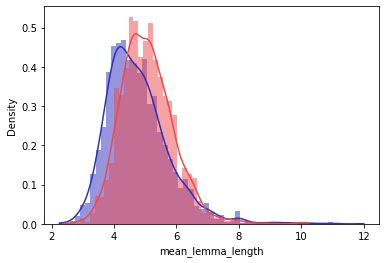

In [64]:
sns.histplot(meta_features_df_train['mean_lemma_length'][y_train==0], **kwargs_distplot, color='#2c2fbf')
sns.histplot(meta_features_df_train['mean_lemma_length'][y_train==1], **kwargs_distplot, color='#f14848')


In [65]:
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################
######################################################################################################

In [66]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [67]:
tfidf = TfidfVectorizer(
    max_features=50,
    # binary=True
    )
X_train_vec = tfidf.fit_transform(X_train['lemmas_no_sw'].apply(lambda x: ' '.join(x)))
X_train_vec_df = pd.DataFrame(
    X_train_vec.toarray(), columns=tfidf.get_feature_names(), index=X_train.index
    )
X_train_combined_df = pd.concat(
    [
        X_train_vec_df, 
        pos_vectorized_df_train, 
        ner_vectorized_df_train, 
        meta_features_df_train
    ],
    axis=1
    )
X_train_combined_df.head()

,attack,bag,body,bomb,building,burn,california,car,collapse,come,...,GPE,LOC,NORP,ORG,has_url,character_count,sw_count,mean_lemma_length,lemma_count_no_sw,unique_lemmas_no_sw
1489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,135,15,4.818182,7,7
5973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,33,0,6.500000,2,2
7589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,14,0,6.500000,2,2
3788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,133,14,3.678571,10,10
825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,48,4,4.000000,4,4


In [68]:
X_train_combined_df_scaled = StandardScaler().fit_transform(X_train_combined_df)
X_train_combined_df_scaled = pd.DataFrame(X_train_combined_df_scaled, index=X_train.index, columns=X_train_combined_df.columns)

In [69]:
###########################################################

In [70]:
X_train_combined_df_scaled.shape

(5709, 78)

In [71]:
from keras import models
from keras import layers
from keras import regularizers
from tensorflow.keras.metrics import Precision, Recall, AUC
baseline_model = models.Sequential()

baseline_model.add(layer=layers.Dense(
    units=50,
    activation='relu',
    input_shape=(X_train_combined_df_scaled.shape[1],)
))

baseline_model.add(layer=layers.Dense(
    units=25,
    activation='relu'
))

baseline_model.add(layer=layers.Dense(
    units=1,
    activation='sigmoid'
))

In [72]:
baseline_model.compile(
    optimizer='SGD',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [73]:
baseline_model_val = baseline_model.fit(
    np.array(X_train_combined_df_scaled),
    np.array(y_train),
    epochs=150,
    batch_size=64,
    validation_split=.2
)

Epoch 1/150
72/72 [==============================] - 0s 5ms/step - loss: 0.7227 - accuracy: 0.5336 - val_loss: 0.6931 - val_accuracy: 0.5613
Epoch 2/150
72/72 [==============================] - 0s 1ms/step - loss: 0.6761 - accuracy: 0.5818 - val_loss: 0.6637 - val_accuracy: 0.6025
Epoch 3/150
72/72 [==============================] - 0s 1ms/step - loss: 0.6488 - accuracy: 0.6192 - val_loss: 0.6433 - val_accuracy: 0.6384
Epoch 4/150
72/72 [==============================] - 0s 1ms/step - loss: 0.6289 - accuracy: 0.6488 - val_loss: 0.6280 - val_accuracy: 0.6541
Epoch 5/150
72/72 [==============================] - 0s 1ms/step - loss: 0.6128 - accuracy: 0.6626 - val_loss: 0.6162 - val_accuracy: 0.6629
Epoch 6/150
72/72 [==============================] - 0s 2ms/step - loss: 0.5992 - accuracy: 0.6786 - val_loss: 0.6064 - val_accuracy: 0.6760
Epoch 7/150
72/72 [==============================] - 0s 1ms/step - loss: 0.5874 - accuracy: 0.6884 - val_loss: 0.5979 - val_accuracy: 0.6848
Epoch 8/150
7

In [74]:
###########################################################

In [75]:
some_model = RandomForestClassifier()
cross_val_score(some_model, X_train_combined_df, y_train, cv=5)

array([0.7408056 , 0.7530648 , 0.73642732, 0.7267951 , 0.73093777])

In [76]:
some_model.fit(X_train_combined_df_scaled, y_train)

RandomForestClassifier()

In [77]:
sorted(list(zip(X_train_combined_df_scaled.columns, some_model.feature_importances_.tolist())), key=lambda x: x[1], reverse=True)

[('mean_lemma_length', 0.09300946455981285),
 ('character_count', 0.08359207496280366),
 ('unique_lemmas_no_sw', 0.049832806831698225),
 ('sw_count', 0.04920313247466853),
 ('NOUN', 0.04819169228903639),
 ('lemma_count_no_sw', 0.047734541785847205),
 ('ADP', 0.042650640881839605),
 ('PRON', 0.04032178044613627),
 ('PROPN', 0.03746465020605524),
 ('VERB', 0.03519847761225173),
 ('ADJ', 0.030958725507841272),
 ('GPE', 0.03073061117524888),
 ('has_url', 0.02724530402125442),
 ('AUX', 0.024105708393457426),
 ('DET', 0.022541994697006486),
 ('ADV', 0.021661393375741685),
 ('fire', 0.017190705147611715),
 ('PART', 0.01701555593012378),
 ('CCONJ', 0.015432771196025338),
 ('SCONJ', 0.013004606890481317),
 ('new', 0.010519880165749146),
 ('train', 0.009883060243108715),
 ('NORP', 0.009360232882624185),
 ('storm', 0.009128937697894354),
 ('ORG', 0.00906197987986611),
 ('kill', 0.00794945838760652),
 ('INTJ', 0.007414908420857297),
 ('like', 0.007313138844331921),
 ('disaster', 0.0070226314578810